### Music Recommendation System using Spotify API

In [1]:
import requests 
import base64

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import spotipy

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
pd.set_option('display.max_column', 30)
plt.style.use('Solarize_Light2') 

### Set up Spotify API

In [2]:
CLIENT_ID = 'bf8aa0027aec4616be511842c612aaf8'
CLIENT_SECRET = '5dc99c11523e4e1987f166a26069bdcf'

client_credentials = f"{CLIENT_ID}:{CLIENT_SECRET}"
client_credentials_base64 = base64.b64encode(client_credentials.encode())

token_url = 'https://accounts.spotify.com/api/token'
headers = {
    'Authorization': f'Basic {client_credentials_base64.decode()}'
}
data = {
    'grant_type': 'client_credentials'
}
response = requests.post(token_url, data=data, headers=headers)

if response.status_code == 200:
    access_token = response.json()['access_token']
    print("Success")
else:
    print("Error obtaining access token.")
    exit()

Success


### Extract data 


#### What are the key features requried to recommend music? 

"There are essentially two types of track representations: Collaborative filtering and Content-based filtering. 

    Track title
    Release title
    Artist name
    Featured artists
    Songwriter credits
    Producers credits
    Label
    Release Date
    Genre & sub-genre tags* 
    Music culture tags*
    Mood tags*
    Style tags*
    Primary language*
    Instruments used throughout recording*
    Track typology (Is it a cover? Is it a remix? Is it an instrumental?)
    Artist hometown/local market*
    Dancebility
    Energy
    Valence 
    Explicit/Implicit
These are some features that fall under the track representation and there are many NLP models and clustering models used to recommend the user" 
https://www.music-tomorrow.com/blog/how-spotify-recommendation-system-works-a-complete-guide-2022

In [3]:
def get_playlist_df(playlist_id, access_token):
   
    sp = spotipy.Spotify(auth=access_token)
    data = []
    #Get tracks from the playlist
    plyst_tracks = sp.playlist_tracks(playlist_id, fields='items, uri, name, track')
    
    for track_info in plyst_tracks['items']:
        track = track_info['track']
        track_name = track['name']
        artists = ', '.join([artist['name'] for artist in track['artists']])
        album_name = track['album']['name']
        album_id = track['album']['id']
        track_id = track['id']
        release_date = sp.album(album_id)['release_date']
        popularity = sp.track(track_id)['popularity']
        explicit = sp.track(track_id)['explicit']
        
        a = sp.artist(track["artists"][0]["external_urls"]["spotify"])
        genre = a['genres']
        
        tract_dict = {
            'Track' : track_name,
            'Artist' : artists,
            'Album' : album_name,
            'Album_id': album_id,
            'Release Date': release_date,
            'Popularity': popularity,
            'Explicit': explicit,
            'Genres': genre
        } 
        
        #The audio_features of each track include danceability, valence, energy, duration, and etc. 
        audio_features = sp.audio_features([track_id])[0] 
        tract_dict.update(audio_features)
        data.append(tract_dict)
    return pd.DataFrame(data)

In [57]:
string = 'https://open.spotify.com/playlist/280hYAs0wM3CswUTZDVBif?si=ee70d1c813664383'

In [58]:
#Parse the playlist id from your Spotify playlist link
playlist_id = string.split("/")[-1].split('?')[0]

In [59]:
df = get_playlist_df(playlist_id, access_token)

In [60]:
df.shape

(100, 26)

In [61]:
df.head()

,Track,Artist,Album,Album_id,Release Date,Popularity,Explicit,Genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Last Breath,Future,CREED: Original Motion Picture Soundtrack,6Vl1FiigNmVpKDMXpRVUCA,2015-11-20,66,True,"[atl hip hop, hip hop, rap, southern hip hop, ...",0.675,0.758,4,-4.589,0,0.0368,0.43100,0.00177,0.3770,0.1520,89.982,audio_features,4Arjo1XR9qXsLstvU9fFV3,spotify:track:4Arjo1XR9qXsLstvU9fFV3,https://api.spotify.com/v1/tracks/4Arjo1XR9qXs...,https://api.spotify.com/v1/audio-analysis/4Arj...,239800,4
1,Lose Yourself,Eminem,Just Lose It,1rfORa9iYmocEsnnZGMVC4,2004-01-01,83,True,"[detroit hip hop, hip hop, rap]",0.686,0.735,2,-4.616,1,0.2640,0.00921,0.00066,0.3420,0.0596,171.355,audio_features,1v7L65Lzy0j0vdpRjJewt1,spotify:track:1v7L65Lzy0j0vdpRjJewt1,https://api.spotify.com/v1/tracks/1v7L65Lzy0j0...,https://api.spotify.com/v1/audio-analysis/1v7L...,322227,4
2,I'd Love To Change The World - Matstubs Remix,"Jetta, Matstubs",I'd Love To Change The World (Matstubs Remix),6Rrkbe2xgFPfCF2frnzUg3,2015-12-18,64,False,[metropopolis],0.459,0.796,4,-5.226,0,0.1320,0.07610,0.00908,0.0633,0.2180,139.913,audio_features,6ce17pZwsMcYNab5IaC5MQ,spotify:track:6ce17pZwsMcYNab5IaC5MQ,https://api.spotify.com/v1/tracks/6ce17pZwsMcY...,https://api.spotify.com/v1/audio-analysis/6ce1...,189973,4
3,Beast - Southpaw Remix,"Rob Bailey & The Hustle Standard, Busta Rhymes...",Southpaw (Music From And Inspired By The Motio...,21CZUn61aoVz08xU4wwfru,2015-07-24,65,True,[military rap],0.596,0.947,9,-4.514,1,0.2180,0.02520,0.00000,0.8880,0.5550,143.991,audio_features,2fWSwWmKRuyioqIzOzuQGo,spotify:track:2fWSwWmKRuyioqIzOzuQGo,https://api.spotify.com/v1/tracks/2fWSwWmKRuyi...,https://api.spotify.com/v1/audio-analysis/2fWS...,279373,4
4,Red Nation,"The Game, Lil Wayne",The R.E.D. Album,6PvZnd9Q2ymDo3gpoM5I37,2011-01-01,64,True,"[gangster rap, hip hop, pop rap, rap, southern...",0.405,0.889,2,-3.303,1,0.3170,0.09220,0.00000,0.4460,0.3380,82.918,audio_features,2sYUGgzQfHQ6lOWzbrny8Z,spotify:track:2sYUGgzQfHQ6lOWzbrny8Z,https://api.spotify.com/v1/tracks/2sYUGgzQfHQ6...,https://api.spotify.com/v1/audio-analysis/2sYU...,229480,4


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Track             100 non-null    object 
 1   Artist            100 non-null    object 
 2   Album             100 non-null    object 
 3   Album_id          100 non-null    object 
 4   Release Date      100 non-null    object 
 5   Popularity        100 non-null    int64  
 6   Explicit          100 non-null    bool   
 7   Genres            100 non-null    object 
 8   danceability      100 non-null    float64
 9   energy            100 non-null    float64
 10  key               100 non-null    int64  
 11  loudness          100 non-null    float64
 12  mode              100 non-null    int64  
 13  speechiness       100 non-null    float64
 14  acousticness      100 non-null    float64
 15  instrumentalness  100 non-null    float64
 16  liveness          100 non-null    float64
 17

In [63]:
df.describe()

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,45.230000,0.627440,0.785330,4.680000,-5.389740,0.500000,0.152988,0.094700,0.153953,0.234538,0.387493,125.170090,202338.070000,3.900000
std,24.967799,0.153391,0.135088,3.792283,2.516377,0.502519,0.115185,0.144309,0.303106,0.179342,0.209509,30.963729,56569.154711,0.481999
min,0.000000,0.228000,0.438000,0.000000,-14.522000,0.000000,0.031900,0.000262,0.000000,0.050900,0.034400,71.989000,61344.000000,1.000000
25%,31.750000,0.509750,0.700500,1.000000,-6.587000,0.000000,0.058075,0.008595,0.000000,0.105500,0.239000,95.055250,165491.250000,4.000000
50%,48.000000,0.643000,0.807000,4.000000,-5.164000,0.500000,0.109000,0.025500,0.000137,0.157500,0.372000,128.777000,192720.000000,4.000000
75%,64.000000,0.746750,0.896000,8.000000,-3.958250,1.000000,0.233500,0.104500,0.053200,0.336750,0.528000,149.875500,237550.000000,4.000000
max,88.000000,0.901000,0.997000,11.000000,1.823000,1.000000,0.560000,0.549000,0.965000,0.888000,0.937000,189.698000,453987.000000,5.000000


In [64]:
df.isnull().sum()

Track               0
Artist              0
Album               0
Album_id            0
Release Date        0
Popularity          0
Explicit            0
Genres              0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
type                0
id                  0
uri                 0
track_href          0
analysis_url        0
duration_ms         0
time_signature      0
dtype: int64

In [65]:
df.isna().sum()

Track               0
Artist              0
Album               0
Album_id            0
Release Date        0
Popularity          0
Explicit            0
Genres              0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
type                0
id                  0
uri                 0
track_href          0
analysis_url        0
duration_ms         0
time_signature      0
dtype: int64

In [66]:
df = df.drop(['type', 'uri', 'analysis_url', 'time_signature'], axis=1)

In [67]:
df.head()

,Track,Artist,Album,Album_id,Release Date,Popularity,Explicit,Genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,track_href,duration_ms
0,Last Breath,Future,CREED: Original Motion Picture Soundtrack,6Vl1FiigNmVpKDMXpRVUCA,2015-11-20,66,True,"[atl hip hop, hip hop, rap, southern hip hop, ...",0.675,0.758,4,-4.589,0,0.0368,0.43100,0.00177,0.3770,0.1520,89.982,4Arjo1XR9qXsLstvU9fFV3,https://api.spotify.com/v1/tracks/4Arjo1XR9qXs...,239800
1,Lose Yourself,Eminem,Just Lose It,1rfORa9iYmocEsnnZGMVC4,2004-01-01,83,True,"[detroit hip hop, hip hop, rap]",0.686,0.735,2,-4.616,1,0.2640,0.00921,0.00066,0.3420,0.0596,171.355,1v7L65Lzy0j0vdpRjJewt1,https://api.spotify.com/v1/tracks/1v7L65Lzy0j0...,322227
2,I'd Love To Change The World - Matstubs Remix,"Jetta, Matstubs",I'd Love To Change The World (Matstubs Remix),6Rrkbe2xgFPfCF2frnzUg3,2015-12-18,64,False,[metropopolis],0.459,0.796,4,-5.226,0,0.1320,0.07610,0.00908,0.0633,0.2180,139.913,6ce17pZwsMcYNab5IaC5MQ,https://api.spotify.com/v1/tracks/6ce17pZwsMcY...,189973
3,Beast - Southpaw Remix,"Rob Bailey & The Hustle Standard, Busta Rhymes...",Southpaw (Music From And Inspired By The Motio...,21CZUn61aoVz08xU4wwfru,2015-07-24,65,True,[military rap],0.596,0.947,9,-4.514,1,0.2180,0.02520,0.00000,0.8880,0.5550,143.991,2fWSwWmKRuyioqIzOzuQGo,https://api.spotify.com/v1/tracks/2fWSwWmKRuyi...,279373
4,Red Nation,"The Game, Lil Wayne",The R.E.D. Album,6PvZnd9Q2ymDo3gpoM5I37,2011-01-01,64,True,"[gangster rap, hip hop, pop rap, rap, southern...",0.405,0.889,2,-3.303,1,0.3170,0.09220,0.00000,0.4460,0.3380,82.918,2sYUGgzQfHQ6lOWzbrny8Z,https://api.spotify.com/v1/tracks/2sYUGgzQfHQ6...,229480


### Data Visualization

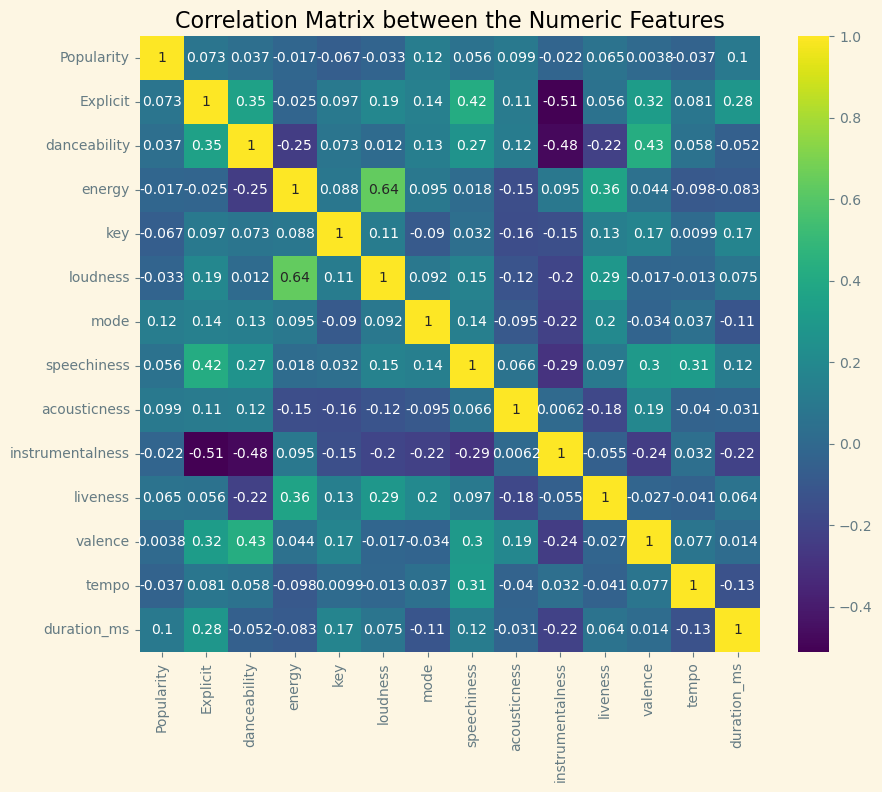

In [68]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='viridis')
plt.title('Correlation Matrix between the Numeric Features')
plt.show()

#### We can observe that energy and loudness, valence and energy,  and danceability and valence have a high correlation

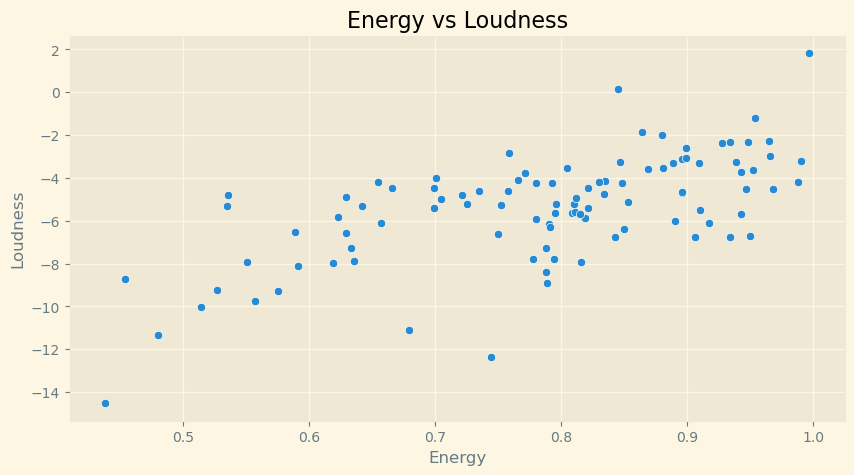

In [69]:
plt.figure(figsize=(10, 5))
sns.scatterplot(df, x='energy', y='loudness')
plt.title('Energy vs Loudness')
plt.xlabel('Energy')
plt.ylabel('Loudness')
plt.show()

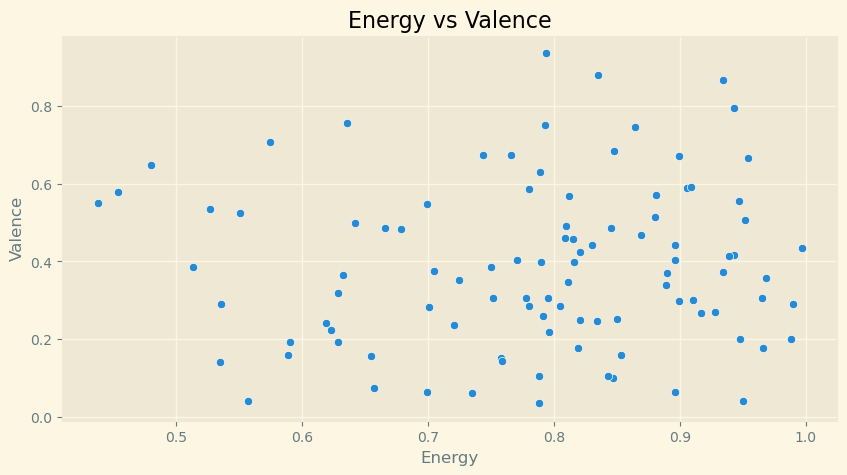

In [70]:
plt.figure(figsize=(10, 5))
sns.scatterplot(df, x='energy', y='valence')
plt.title('Energy vs Valence')
plt.xlabel('Energy')
plt.ylabel('Valence')
plt.show()

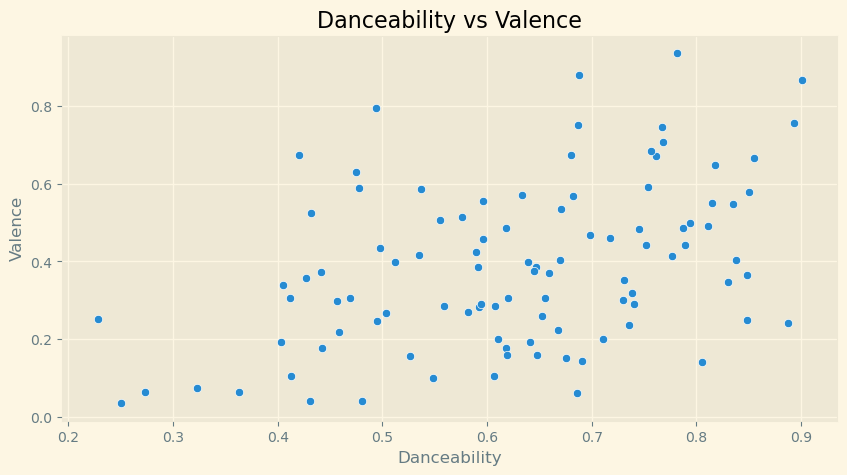

In [71]:
plt.figure(figsize=(10, 5))
sns.scatterplot(df, x='danceability', y='valence')
plt.title('Danceability vs Valence')
plt.xlabel('Danceability')
plt.ylabel('Valence')
plt.show()

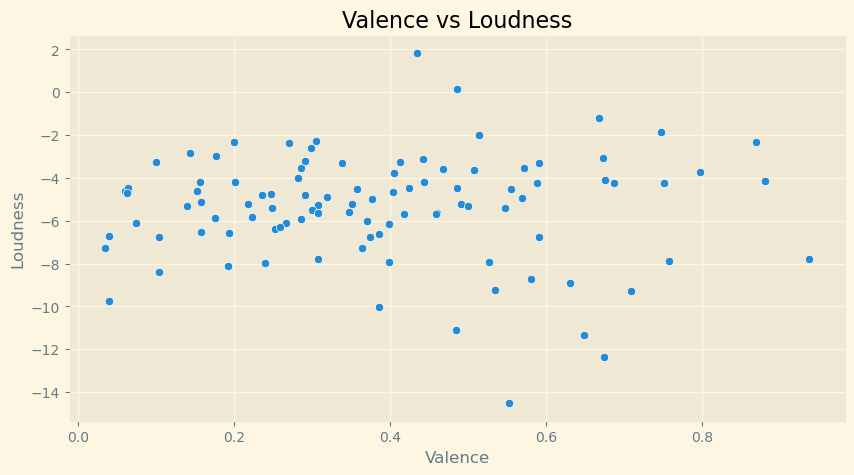

In [72]:
plt.figure(figsize=(10, 5))
sns.scatterplot(df, x='valence', y='loudness')
plt.title('Valence vs Loudness')
plt.xlabel('Valence')
plt.ylabel('Loudness')
plt.show()

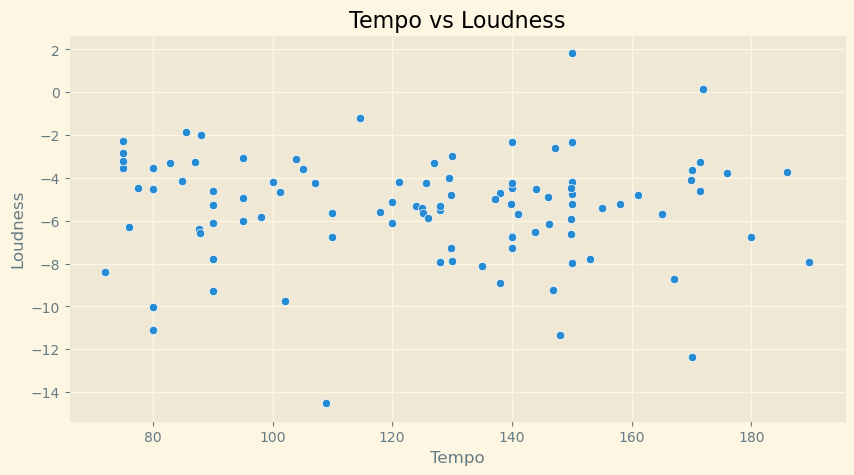

In [73]:
plt.figure(figsize=(10, 5))
sns.scatterplot(df, x='tempo', y='loudness')
plt.title('Tempo vs Loudness')
plt.xlabel('Tempo')
plt.ylabel('Loudness')
plt.show()

<Axes: xlabel='danceability', ylabel='Count'>

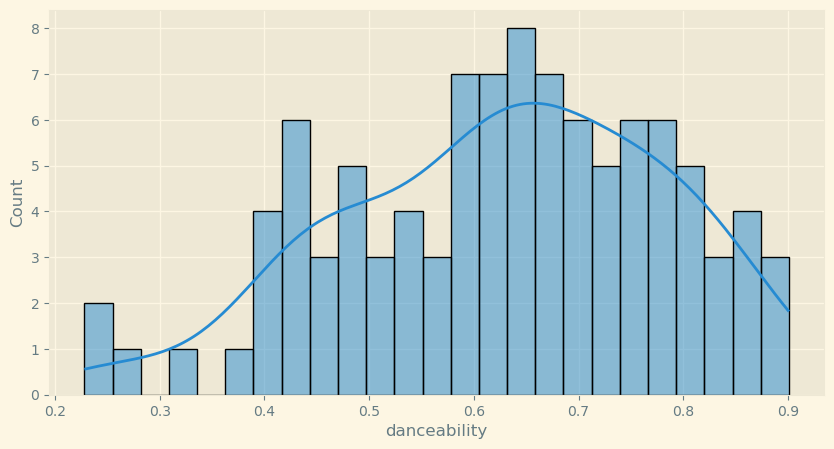

In [74]:
plt.figure(figsize=(10, 5))
sns.histplot(df['danceability'], bins=25, kde=True)

<Axes: xlabel='loudness', ylabel='Count'>

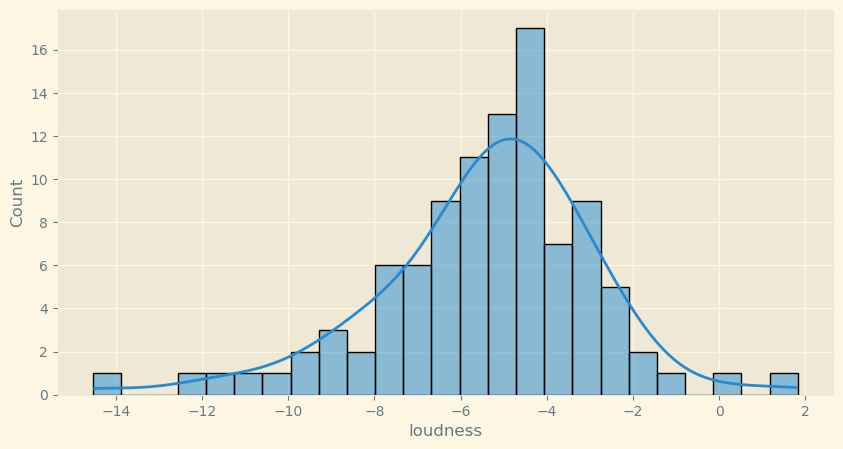

In [75]:
plt.figure(figsize=(10, 5))
sns.histplot(df['loudness'], bins=25, kde=True)

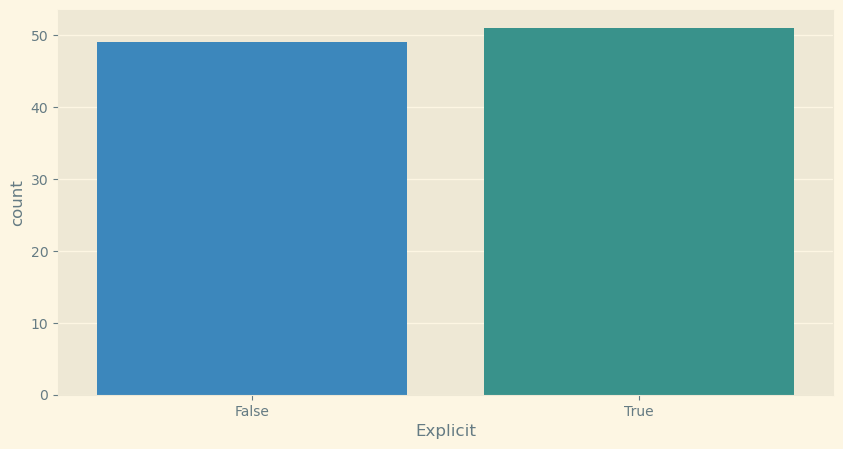

In [76]:
#Depends on the playlist or the overall dataset 
plt.figure(figsize=(10, 5))
sns.countplot(df, x="Explicit")
plt.show()

## Pre Processing

In [91]:
df_continuous = df.select_dtypes(['float64', 'int64']).drop('Popularity', axis=1)

In [126]:
def final_feature(df):
    '''
        Inspired from https://towardsdatascience.com
    '''

    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['Genres'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names_out()]
    genre_df.reset_index(drop = True, inplace=True)

    scaler = MinMaxScaler()
    music_features = df_continuous.values
    scaled_df = pd.DataFrame(scaler.fit_transform(music_features), columns=df_continuous.columns)
    meta_df = df[['Track', 'Album', 'Artist','Popularity','Genres', 'Release Date']]

    final = pd.concat([meta_df, scaled_df, genre_df], axis = 1)
    final['id']=df['id'].values
    
    return final

In [127]:
final_df = final_feature(df)

In [128]:
final_df

,Track,Album,Artist,Popularity,Genres,Release Date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,genre|school,genre|screwed,genre|slap,genre|soft,genre|soundtrack,genre|south,genre|southern,genre|speed,genre|trap,genre|traprun,genre|turkish,genre|uk,genre|viral,genre|west,id
0,Last Breath,CREED: Original Motion Picture Soundtrack,Future,66,"[atl hip hop, hip hop, rap, southern hip hop, ...",2015-11-20,0.664190,0.572451,0.363636,0.607709,0.0,0.009279,0.784961,0.001834,0.389559,...,0.0,0.0,0.0,0.0,0.0,0.0,0.276981,0.0,0.221311,0.0,0.0,0.0,0.000000,0.0,4Arjo1XR9qXsLstvU9fFV3
1,Lose Yourself,Just Lose It,Eminem,83,"[detroit hip hop, hip hop, rap]",2004-01-01,0.680535,0.531306,0.181818,0.606057,1.0,0.439500,0.016307,0.000684,0.347748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1v7L65Lzy0j0vdpRjJewt1
2,I'd Love To Change The World - Matstubs Remix,I'd Love To Change The World (Matstubs Remix),"Jetta, Matstubs",64,[metropopolis],2015-12-18,0.343239,0.640429,0.363636,0.568737,0.0,0.189547,0.138204,0.009409,0.014813,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,6ce17pZwsMcYNab5IaC5MQ
3,Beast - Southpaw Remix,Southpaw (Music From And Inspired By The Motio...,"Rob Bailey & The Hustle Standard, Busta Rhymes...",65,[military rap],2015-07-24,0.546805,0.910555,0.818182,0.612297,1.0,0.352395,0.045446,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,2fWSwWmKRuyioqIzOzuQGo
4,Red Nation,The R.E.D. Album,"The Game, Lil Wayne",64,"[gangster rap, hip hop, pop rap, rap, southern...",2011-01-01,0.263001,0.806798,0.181818,0.686387,1.0,0.539860,0.167544,0.000000,0.471987,...,0.0,0.0,0.0,0.0,0.0,0.0,0.290824,0.0,0.232372,0.0,0.0,0.0,0.000000,0.0,2sYUGgzQfHQ6lOWzbrny8Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,King Kong,King Kong,DeStorm Power,48,[viral pop],2017-01-07,0.630015,0.631485,0.090909,0.503028,0.0,0.119864,0.183581,0.000000,0.087325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.870569,0.0,2ZPwksPdZwvpgkxuxcBdYu
96,300 Violin Orchestra,Hip Hop and Rnb Instrmentals,Jorge Quintero,62,[],2008-07-02,0.539376,0.558140,0.090909,0.484735,0.0,0.030297,0.622771,0.376166,0.035241,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,4JjUwfp8GQ3PxWg2QPKnpn
97,PENDULUM,CIRCUS,"Kill the Clowns, Multi",16,[],2023-08-18,0.543834,0.987478,0.090909,0.692628,1.0,0.458436,0.045446,0.000059,0.663123,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,2zjn72gKbNAouSiD53qQAd
98,Wimbledon Interlude,Wimbledon Interlude,"Austin Awake, Jden Ray",41,[],2023-08-04,0.613670,0.341682,0.909091,0.485714,0.0,0.553115,0.062212,0.000000,0.078963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,5SPxR92whNhwfLcynGCU97


## Make Content Based Recommendations

In [162]:
def get_content_recommendations(song_name, final, rec=5):
    if song_name not in final['Track'].values:
        print(f"'{song_name}' not found in the dataset.")
        return
    
    input_song_index = final[final['Track'] == song_name].index[0]
    similar_song_indices = np.argsort(cosine_similarity([scaled_data[input_song_index]], scaled_data))[0][::-1][1:rec+1]
    content_based_recommendations = final.iloc[similar_song_indices][['Track', 'Artist', 'Album', 'Release Date', 'Genres', 'Popularity']]

    return content_based_recommendations.sort_values('Popularity')

In [163]:
get_content_recommendations('Lose Yourself', final_df)

,Track,Artist,Album,Release Date,Genres,Popularity
13,1520,"Rasheed Chappell, The Arcitype",1520,2023-08-11,[boom bap],42
40,Frag Out,DJ Assass1n,Frag Out,2012-01-01,[],47
12,U AND ME,LINK,U AND ME EP,2023-08-04,[speed house],47
54,Invincible,Two Steps from Hell,Invincible,2010-05-03,"[epicore, orchestral soundtrack]",52
18,Remember the Name (feat. Styles of Beyond),"Fort Minor, Styles Of Beyond",The Rising Tied (Deluxe Edition),2005-11-21,[rap rock],56
